In [ ]:
!pip install praw


In [ ]:
!pip install textblob

In [ ]:
import praw
import time
import csv
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from datetime import datetime
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Парсинг постов с Reddit

In [ ]:
import praw
import time
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import csv

# Настройка Reddit API
reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=CLIENT_SECRET,
                     user_agent=USER_AGENT)

subreddit = reddit.subreddit('news')
posts = []

def define_category(title, text):
    info = title + " " + text
    # Токенизация и удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    texts = [[word for word in word_tokenize(info.lower()) if word.isalpha() and word not in stop_words]]

    # Создание словаря и корпуса
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Построение LDA модели
    num_topics = 8
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Получение тем и их весов для текущего документа
    document_topics = lda.get_document_topics(corpus[0])
    document_topics.sort(key=lambda x: x[1], reverse=True)  # Сортируем по весу

    primary_topic_index = document_topics[0][0]
    secondary_topic_index = document_topics[1][0] if len(document_topics) > 1 else None

    # Получение слов для тем
    topic_words = lda.show_topics(num_topics=num_topics, formatted=False)
    topic_labels = {i: " ".join([word[0] for word in words]) for i, words in topic_words}

    # Получаем названия тем
    primary_category = topic_labels[primary_topic_index]
    secondary_category = topic_labels[secondary_topic_index] if secondary_topic_index is not None else None

    # Допустимый порог для разницы весов
    threshold = 0.1

    if secondary_category and (document_topics[0][1] - document_topics[1][1] > threshold):
        return primary_category, secondary_category  # Возвращаем названия тем
    else:
        return primary_category, None  # Возвращаем только первую тему

# Функция для анализа тональности с использованием NaiveBayesAnalyzer
def analyze_sentiment_nb(text):
    if text:
        blob = TextBlob(text, analyzer=NaiveBayesAnalyzer())
        sentiment = blob.sentiment.classification  # 'pos' или 'neg'
        if sentiment == 'pos':
            sentiment_label = 'positive'
        else:
            sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'
    return sentiment_label

# Функция для подсчета изображений (в URL или вложенные)
def count_images(submission):
    image_count = 0

    # Подсчет изображений по URL (jpg, png, gif)
    if hasattr(submission, 'url'):
        if submission.url.lower().endswith(('.jpg', '.png', '.gif')):
            image_count += 1

    # Проверка наличия изображений, загруженных в пост через Reddit
    if hasattr(submission, 'media_metadata'):
        image_count += len(submission.media_metadata)

    if hasattr(submission, 'preview'):
        if 'images' in submission.preview:
            image_count += len(submission.preview['images'])

    return image_count

# Функция для подсчета ссылок в тексте и заголовке
def count_links(text, title):
    link_count = 0
    combined_text = title + " " + text
    if combined_text:
        link_count = combined_text.count('http://') + combined_text.count('https://')
    return link_count

# Функция для преобразования времени публикации
def get_post_date_time(utc_timestamp):
    post_datetime = datetime.utcfromtimestamp(utc_timestamp)
    post_date = post_datetime.strftime('%Y-%m-%d')  # Дата в формате ГГГГ-ММ-ДД
    post_time = post_datetime.strftime('%H:%M:%S')  # Время в формате ЧЧ:ММ:СС
    return post_date, post_time

# Получаем 500 постов с таймером
for submission in subreddit.new(limit=1000):
    # Анализируем текст и заголовок
    title = submission.title or ''
    text = submission.selftext or ''  # Если пост без текста, вернуть пустую строку
    text_length = len(title) + len(text)  # Длина текста + заголовок

    # Анализ тональности заголовка и текста отдельно
    title_sentiment_label = analyze_sentiment_nb(title)
    text_sentiment_label = analyze_sentiment_nb(text)

    # Подсчет количества изображений
    image_count = count_images(submission)

    # Подсчет количества ссылок в заголовке и тексте
    link_count = count_links(text, title)

    # Получение категорий поста
    primary_category, secondary_category = define_category(title, text)

    # Получение даты и времени публикации
    post_date, post_time = get_post_date_time(submission.created_utc)

    posts.append({
        'title': submission.title,
        'url': submission.url,
        'created_utc': submission.created_utc,
        'post_date': post_date,
        'post_time': post_time,
        'score': submission.score,
        'text_length': text_length,
        'image_count': image_count,
        'link_count': link_count,
        'title_sentiment': title_sentiment_label,
        'text_sentiment': text_sentiment_label,
        'primary_category': primary_category,   # Первая тема
        'secondary_category': secondary_category  # Вторая тема
    })

    # Пауза на 1 секунду между запросами
    time.sleep(1)

# Записываем данные в CSV файл
with open('/content/drive/My Drive/Colab Notebooks/news_posts_finally_end.csv', mode='w', newline='', encoding='utf-8') as csv_file:
    fieldnames = ['title', 'url', 'created_utc', 'post_date', 'post_time', 'score', 'text_length', 'image_count', 'link_count', 'title_sentiment', 'text_sentiment', 'primary_category', 'secondary_category']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    # Записываем заголовки столбцов
    writer.writeheader()
    # Записываем данные
    for post in posts:
        writer.writerow(post)


print("Данные успешно записаны в news_posts_finally.csv")


In [ ]:
# files.download('C:Users/ritac\Desktop/r/news_posts_finally.csv')

In [ ]:

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/news_posts_finally_end.csv')

In [ ]:

data.head()

,title,url,created_utc,post_date,post_time,score,text_length,image_count,link_count,title_sentiment,text_sentiment,primary_category,secondary_category
0,Museum’s beer can artwork accidentally thrown ...,https://www.cnn.com/2024/10/08/style/beer-can-...,1.728405e+09,2024-10-08,16:29:58,1682,70,1,0,positive,neutral,beer museum accidentally staff artwork member ...,thrown artwork member museum accidentally staf...
1,States sue TikTok over app's effect on kids' m...,https://www.cnbc.com/2024/10/08/tiktok-sued-dc...,1.728397e+09,2024-10-08,14:20:05,2153,58,1,0,positive,neutral,health tiktok app effect kids mental states sue,kids states app effect health mental sue tiktok
2,Ohio girl concedes cutting off tanker that spi...,https://www.wandtv.com/news/ohio-girl-concedes...,1.728388e+09,2024-10-08,11:52:17,9427,92,1,0,negative,neutral,cutting illinois spilled concedes girl year la...,chemical concedes girl illinois killing last o...
3,Al Pacino says he briefly died from Covid: 'I ...,https://www.nbcnews.com/news/us-news/al-pacino...,1.728349e+09,2024-10-08,00:59:42,4193,55,1,0,positive,neutral,al gone briefly covid died pacino says,died briefly covid gone pacino says al
4,The mayor of a state capital in Mexico is kill...,https://apnews.com/article/mexico-guerrero-chi...,1.728345e+09,2024-10-07,23:51:18,4671,86,1,0,positive,neutral,week mayor office killed took state mexico cap...,less capital mexico state took killed office m...


In [ ]:
data.describe()

,created_utc,score,text_length,image_count,link_count
count,1.650000e+02,165.000000,165.000000,165.000000,165.0
mean,1.727938e+09,5633.787879,78.557576,0.890909,0.0
std,2.323844e+05,7392.500006,19.117529,0.312702,0.0
min,1.727512e+09,129.000000,28.000000,0.000000,0.0
25%,1.727738e+09,1149.000000,66.000000,1.000000,0.0
50%,1.727961e+09,2697.000000,78.000000,1.000000,0.0
75%,1.728094e+09,6913.000000,91.000000,1.000000,0.0
max,1.728405e+09,46841.000000,144.000000,1.000000,0.0


In [ ]:
data["log_score"] = np.log1p(data['score'])

In [ ]:
# data.drop(columns= 'link_count',axis = 1,inplace = True)

In [ ]:
# data.drop(columns= 'link_count',axis = 1,inplace = True)

In [ ]:
# data.drop(columns= 'secondary_category',axis = 1,inplace = True)

Выберу Standard Scaler , но надо попробовать и минмакс позже

In [ ]:
scaler_r = RobustScaler()
data['log_score'] = scaler_r.fit_transform(data[['log_score']])
scaler_std = StandardScaler()
data['text_length_sc'] = scaler_std.fit_transform(data[['text_length']])


In [ ]:
data.head()

,title,url,created_utc,post_date,post_time,score,text_length,image_count,link_count,title_sentiment,text_sentiment,primary_category,secondary_category,log_score,text_length_sc
0,Museum’s beer can artwork accidentally thrown ...,https://www.cnn.com/2024/10/08/style/beer-can-...,1.728405e+09,2024-10-08,16:29:58,1682,70,1,0,positive,neutral,beer museum accidentally staff artwork member ...,thrown artwork member museum accidentally staf...,-0.263093,-0.448992
1,States sue TikTok over app's effect on kids' m...,https://www.cnbc.com/2024/10/08/tiktok-sued-dc...,1.728397e+09,2024-10-08,14:20:05,2153,58,1,0,positive,neutral,health tiktok app effect kids mental states sue,kids states app effect health mental sue tiktok,-0.125536,-1.078599
2,Ohio girl concedes cutting off tanker that spi...,https://www.wandtv.com/news/ohio-girl-concedes...,1.728388e+09,2024-10-08,11:52:17,9427,92,1,0,negative,neutral,cutting illinois spilled concedes girl year la...,chemical concedes girl illinois killing last o...,0.697504,0.705287
3,Al Pacino says he briefly died from Covid: 'I ...,https://www.nbcnews.com/news/us-news/al-pacino...,1.728349e+09,2024-10-08,00:59:42,4193,55,1,0,positive,neutral,al gone briefly covid died pacino says,died briefly covid gone pacino says al,0.245929,-1.236001
4,The mayor of a state capital in Mexico is kill...,https://apnews.com/article/mexico-guerrero-chi...,1.728345e+09,2024-10-07,23:51:18,4671,86,1,0,positive,neutral,week mayor office killed took state mexico cap...,less capital mexico state took killed office m...,0.306099,0.390484


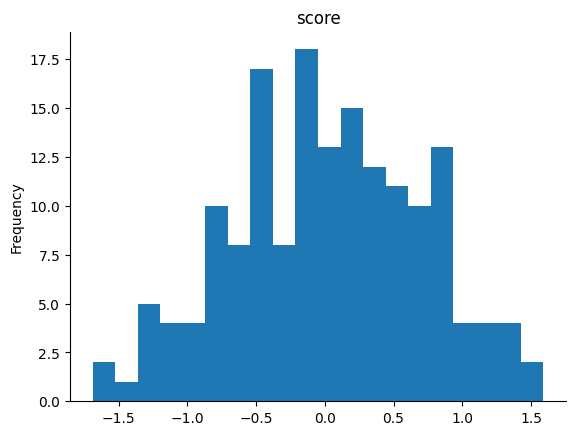

In [ ]:
# @title score

from matplotlib import pyplot as plt
data['log_score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data['title_sentiment_encoded'] = data['title_sentiment'].apply(lambda x: 1 if x == 'positive' else -1)
data['image_count_encoded'] = data['image_count'].apply(lambda x: 1 if x > 0 else -1)

Тк тем для очень много для энкодинга , то мы будем векторизовать


In [ ]:
combined_string = ' '.join(data['primary_category']).split()
set_of_words = set(combined_string)
print(len(set_of_words))

1012


In [ ]:
# Обработка заголовков
data['title'] = data['title'].str.strip().str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Векторизация заголовков
vectorizer = TfidfVectorizer(max_features=1000,ngram_range = (1,3))
title_vector = vectorizer.fit_transform(data['title']).toarray()

print(title_vector.shape)
#Обработка тем для заголовков
category_vector = vectorizer.fit_transform(data['primary_category']).toarray()


df_vectors = pd.DataFrame(title_vector, columns=[f'feature_{i}' for i in range(title_vector.shape[1])])
df_vector2= pd.DataFrame(category_vector, columns=[f'feature_{i}' for i in range(category_vector.shape[1])])
# 3. Объединение оригинального DataFrame с векторизованными данными
data = pd.concat([data, df_vectors,df_vector2], axis=1)

(165, 1000)


In [ ]:

data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')

# Объедините post_date и post_time в одну колонку
data['post_datetime'] = pd.to_datetime(data['post_date'] + ' ' + data['post_time'])

# Извлеките новые признаки
data['year'] = data['post_datetime'].dt.year
data['month'] = data['post_datetime'].dt.month
data['day'] = data['post_datetime'].dt.day
data['day_of_week'] = data['post_datetime'].dt.dayofweek  # 0 = понедельник, 6 = воскресенье
data['hour'] = data['post_datetime'].dt.hour
data['minute'] = data['post_datetime'].dt.minute



In [ ]:
data.head()

,title,url,created_utc,post_date,post_time,score,text_length,image_count,link_count,title_sentiment,...,feature_997,feature_998,feature_999,post_datetime,year,month,day,day_of_week,hour,minute
0,museums beer can artwork accidentally thrown i...,https://www.cnn.com/2024/10/08/style/beer-can-...,2024-10-08 16:29:58,2024-10-08,16:29:58,1682,70,1,0,positive,...,0.0,0.0,0.000000,2024-10-08 16:29:58,2024,10,8,1,16,29
1,states sue tiktok over apps effect on kids men...,https://www.cnbc.com/2024/10/08/tiktok-sued-dc...,2024-10-08 14:20:05,2024-10-08,14:20:05,2153,58,1,0,positive,...,0.0,0.0,0.000000,2024-10-08 14:20:05,2024,10,8,1,14,20
2,ohio girl concedes cutting off tanker that spi...,https://www.wandtv.com/news/ohio-girl-concedes...,2024-10-08 11:52:17,2024-10-08,11:52:17,9427,92,1,0,negative,...,0.0,0.0,0.296502,2024-10-08 11:52:17,2024,10,8,1,11,52
3,al pacino says he briefly died from covid i wa...,https://www.nbcnews.com/news/us-news/al-pacino...,2024-10-08 00:59:42,2024-10-08,00:59:42,4193,55,1,0,positive,...,0.0,0.0,0.000000,2024-10-08 00:59:42,2024,10,8,1,0,59
4,the mayor of a state capital in mexico is kill...,https://apnews.com/article/mexico-guerrero-chi...,2024-10-07 23:51:18,2024-10-07,23:51:18,4671,86,1,0,positive,...,0.0,0.0,0.000000,2024-10-07 23:51:18,2024,10,7,0,23,51


Будем формировать датасет для обучения

In [ ]:
df = data[['score', 'text_length_sc', 'title_sentiment_encoded', 'image_count_encoded', 'year', 'month', 'day', 'day_of_week', 'hour', 'minute']]
df_pro = pd.concat([df, df_vectors,df_vector2], axis=1)
df_pro.head()

,score,text_length_sc,title_sentiment_encoded,image_count_encoded,year,month,day,day_of_week,hour,minute,...,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999
0,1682,-0.448992,1,1,2024,10,8,1,16,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2153,-1.078599,1,1,2024,10,8,1,14,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,9427,0.705287,-1,1,2024,10,8,1,11,52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296502
3,4193,-1.236001,1,1,2024,10,8,1,0,59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,4671,0.390484,1,1,2024,10,7,0,23,51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
# scaler = StandardScaler()
# df_pro['score'] = scaler.fit_transform(df_pro[['score']])

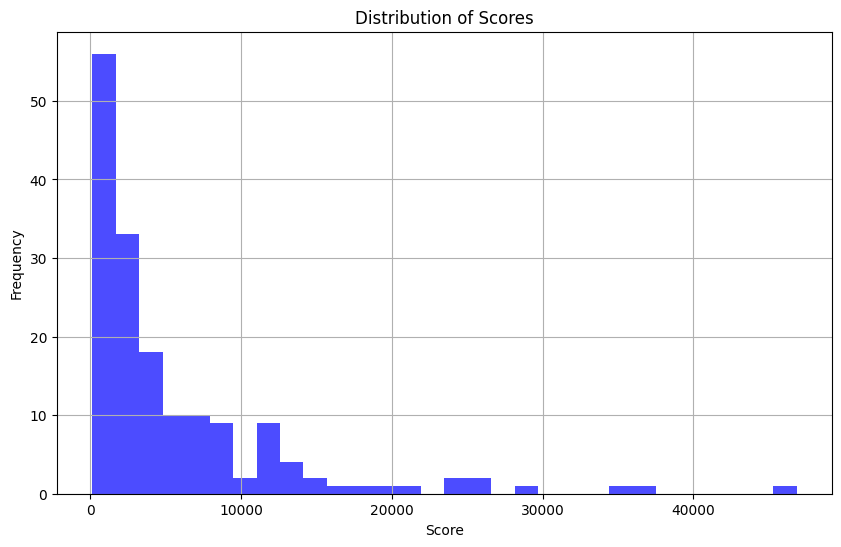

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_pro['score'], bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()


In [ ]:
df_pro.columns

Index(['score', 'text_length_sc', 'title_sentiment_encoded',
       'image_count_encoded', 'year', 'month', 'day', 'day_of_week', 'hour',
       'minute',
       ...
       'feature_990', 'feature_991', 'feature_992', 'feature_993',
       'feature_994', 'feature_995', 'feature_996', 'feature_997',
       'feature_998', 'feature_999'],
      dtype='object', length=2010)

**Построение полносвязной нейронной сети**

In [ ]:
!pip install tensorflow


In [ ]:
scaler = StandardScaler()
y = df_pro['score']


X = df_pro.drop(columns = 'score',axis = 1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.25,random_state = 42)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from tqdm.auto import tqdm

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        self.fc1 = nn.Linear(2009, 1024)
        self.act1 = nn.ReLU()


        self.fc2 = nn.Linear(1024, 512)
        self.act2 = nn.ReLU()


        self.fc3 = nn.Linear(512, 256)
        self.act3 = nn.ReLU()


        self.fc4 = nn.Linear(256, 128)
        self.act4 = nn.ReLU()


        self.fc5 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.act3(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.act4(x)
        x = self.dropout(x)

        x = self.fc5(x)

        return x


In [ ]:
model = Net()
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam оптимизатор
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
lambda_l2 = 0.01
patience = 10


In [ ]:
def train( X_train, y_train,X_val, y_val,model, criterion, optimizer, num_epochs):
    loss_values = []
    best_loss = float('inf')
    counter = 0
    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        l2_reg = sum(param.norm(2) for param in model.parameters())
        loss += lambda_l2 * l2_reg

        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1

        if counter >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            break


    return model,loss_values


In [ ]:
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)

X_val = torch.FloatTensor(X_val.values)
y_val = torch.FloatTensor(y_val.values)


In [ ]:
type(y_val)


torch.Tensor

In [ ]:
model,loss_values = train( X_train, y_train,X_val ,y_val,model,criterion, optimizer, 100)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Train Loss: 99015424.0000, Val Loss: 32459586.0000
Epoch [2/100], Train Loss: 98875112.0000, Val Loss: 32297994.0000
Epoch [3/100], Train Loss: 98629216.0000, Val Loss: 32005734.0000
Epoch [4/100], Train Loss: 98186328.0000, Val Loss: 31518450.0000
Epoch [5/100], Train Loss: 97390000.0000, Val Loss: 30748908.0000
Epoch [6/100], Train Loss: 96251872.0000, Val Loss: 29592486.0000
Epoch [7/100], Train Loss: 94512624.0000, Val Loss: 27951622.0000
Epoch [8/100], Train Loss: 91894432.0000, Val Loss: 25771828.0000
Epoch [9/100], Train Loss: 88317160.0000, Val Loss: 23095834.0000
Epoch [10/100], Train Loss: 83745552.0000, Val Loss: 20179464.0000
Epoch [11/100], Train Loss: 78006872.0000, Val Loss: 17717610.0000
Epoch [12/100], Train Loss: 71911776.0000, Val Loss: 17226346.0000
Epoch [13/100], Train Loss: 66344864.0000, Val Loss: 21570492.0000
Epoch [14/100], Train Loss: 64157492.0000, Val Loss: 33058234.0000
Epoch [15/100], Train Loss: 68275688.0000, Val Loss: 40575080.0000
Epoc

Test Loss: 59327828.0


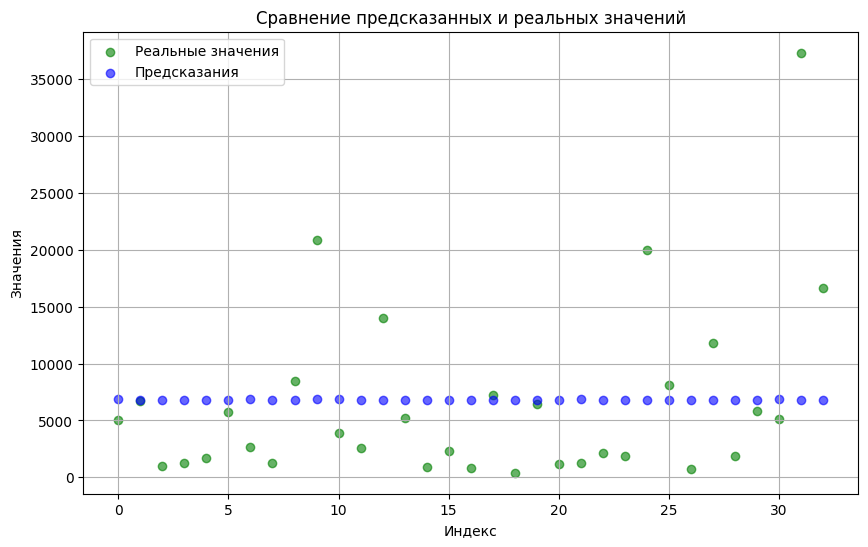

 60252640.0


In [ ]:
# Преобразование в тензоры
X_test_tensor = torch.FloatTensor(X_test.to_numpy())  # Преобразуем DataFrame в тензор

# Предсказания модели
model.eval()
with torch.no_grad():
    nn_prediction = model(X_test_tensor)
    nn_prediction = nn_prediction.numpy()

    loss_function = nn.MSELoss()
    # Преобразуем y_test в тензор
    y_test_tensor = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)  # Преобразуем Series в тензор
    test_loss = loss_function(torch.FloatTensor(nn_prediction), y_test_tensor)  # Вычисляем потери
    print(f'Test Loss: {test_loss.item()}')

# Построение графика
plt.figure(figsize=(10, 6))

# Реальные значения как точки
plt.scatter(range(len(y_test)), y_test, color='green', label='Реальные значения', alpha=0.6)
# y_pred = scaler.inverse_transform(nn_prediction.reshape(-1, 1))
# Предсказания как синие точки
plt.scatter(range(len(nn_prediction)),nn_prediction, color='blue', label='Предсказания', alpha=0.6)

plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значения')
plt.legend()
plt.grid()
plt.show()
print(" 60252640.0")

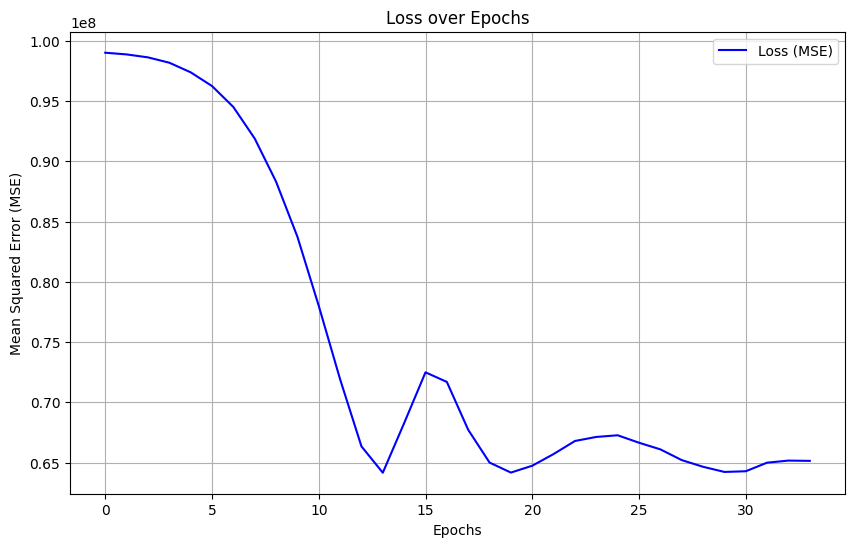

In [ ]:
# Построение графика функции потерь
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Loss (MSE)', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()